# Layer structure

<img src="images/layer_structure.png">

### Important: if target is categorical use Dense(8) if target is binary use Dense(3)
* modelB stands for model that uses binary feature
* modelC stands for model that uses categorical feature

In [41]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Conv2D, Dense, LSTM,MaxPooling2D , Flatten, TimeDistributed,Activation

im_size = 128
time_steps = 16 # len of image sequence
channels = 3
#input_shape=(nr_of_sequences, 16, 227, 227, 3))

#modelB for binary response
modelB = Sequential()
modelB.add(TimeDistributed(Conv2D(filters=96, kernel_size=7,  strides=2, padding='valid'), input_shape=(time_steps,im_size,im_size,channels))) # first input shape is the len of seq
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Conv2D(filters=384, kernel_size=3,  strides=2, padding='valid')))
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(Conv2D(filters=384, kernel_size=3, padding='same')))
modelB.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelB.add(TimeDistributed(Flatten())) #The Flatten layer is only needed because LSTM shape should have one dimension per input.
modelB.add(TimeDistributed(Dense(4096)))
modelB.add(LSTM(256, return_sequences=False)) #pole kindel return_sequence's, kui True, siis multiple outputs
#When return_sequences=True, the output shape is (batch, timeSteps, outputFeatures)
#When return_sequences=False, the output shape is (batch, outputFeatures)
modelB.add((Dense(3))) # for categorical use Dense(8), for binary use Dense(3)
modelB.add((Activation('softmax')))
print(modelB.summary())

#modelC for categorical response
modelC = Sequential()
modelC.add(TimeDistributed(Conv2D(filters=96, kernel_size=7,  strides=2, padding='valid'), input_shape=(time_steps,im_size,im_size,channels))) # first input shape is the len of seq
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Conv2D(filters=384, kernel_size=3,  strides=2, padding='valid')))
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(Conv2D(filters=512, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(Conv2D(filters=384, kernel_size=3, padding='same')))
modelC.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
modelC.add(TimeDistributed(Flatten())) #The Flatten layer is only needed because LSTM shape should have one dimension per input.
modelC.add(TimeDistributed(Dense(4096)))
modelC.add(LSTM(256, return_sequences=False)) #pole kindel return_sequence's, kui True, siis multiple outputs
modelC.add((Dense(8)))
modelC.add((Activation('softmax')))
print(modelC.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_61 (TimeDis (None, 16, 61, 61, 96)    14208     
_________________________________________________________________
time_distributed_62 (TimeDis (None, 16, 30, 30, 96)    0         
_________________________________________________________________
time_distributed_63 (TimeDis (None, 16, 14, 14, 384)   332160    
_________________________________________________________________
time_distributed_64 (TimeDis (None, 16, 7, 7, 384)     0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, 16, 7, 7, 512)     1769984   
_________________________________________________________________
time_distributed_66 (TimeDis (None, 16, 7, 7, 512)     2359808   
_________________________________________________________________
time_distributed_67 (TimeDis (None, 16, 7, 7, 384)    

## Categorical labels

In [42]:
#Encoding the labels
from sklearn.preprocessing import LabelBinarizer
labels = set(['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO'])
print(labels)
lb = LabelBinarizer()
lb.fit(list(labels))
print('categorical labels: \n', lb.transform(['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']))

{'OOO', 'BOO', 'BLR', 'OLO', 'OLR', 'BLO', 'OOR', 'BOR'}
categorical labels: 
 [[0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]


## Binary labels

Comment: following warning can be ignored, it occurs during converting labels into binary 

Warning: .../miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))

In [43]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=['B','L','R'])

def labels_to_binary(ini_labels):
    """
    Takes as input list of labels (e.g. ['BOO', 'BLO', 'BOR'])
    Outputs numpy ndarray of the labels in binary (e.g. [[1 0 0] [1 1 0] [1 0 1])
    """
    labels = []
    for label in ini_labels:
        label_split = list(label) # ['BLO'] -> ['B','L','O']
        labels.append(label_split) # [['B','L','O']]

    return mlb.fit_transform(labels)


ini_labels = ['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']
print('initial labels: \n', ini_labels)
labels_binary = labels_to_binary(ini_labels)
print('labels in binary: \n', labels_binary)

initial labels: 
 ['BOO', 'BLO', 'BOR', 'BLR', 'OLR', 'OLO', 'OOR', 'OOO']
labels in binary: 
 [[1 0 0]
 [1 1 0]
 [1 0 1]
 [1 1 1]
 [0 1 1]
 [0 1 0]
 [0 0 1]
 [0 0 0]]


### Split all non-test folders into train and validation
Train data is 70% and validation is 30%.
Output is list of folder names belonging to training set (train_folder_list) and validation set (valid_folder_list).

In [44]:
from create_train_and_validation import create_train_and_validation_set

path="/Users/liissimmul/Desktop/rear_signal_dataset/"
difficulty="Easy"

train_folder_list, valid_folder_list, test_folder_list, count_train_seq, count_valid_seq, count_test_seq = create_train_and_validation_set(path, difficulty)

total number of non-test folders is  471  for difficulty  Easy
total number of non-test image sequences is  34421
total number of test image sequences is  9069

final train set contains  23928  image sequences ( 70 % )
final validation set contains  10493  image sequences ( 30 % )
final test set contains  9069  image sequences


## Fit generator
Kommentaar: parameetri "aug" kasutus pole hetkel implementeeritud

Source:https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

In [45]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.preprocessing.image import load_img,img_to_array
from load_dataset_numpy import window


class ImageSequenceGenerator:
    
    def __init__(self):
        self.folder_count = 0
        self.seq_count = 0
        self.image_count = 0
        self.folder_list = []


    # label_type: "binary" or "categorical"
    def png_image_generator(self, path, bs, mode="train",difficulty="All", sequence_limit=16, resize_dimension = 128, label_type = "categorical", aug=None):    
        f = open("{0}/{1}.txt".format(path, difficulty))

        if mode == "train":
            self.folder_list = train_folder_list
        elif mode == "valid":
            self.folder_list = valid_folder_list
        elif mode == "test":
            self.folder_list = test_folder_list            
        
        while True:
            X_train = []
            X_test = []
            Y_train = []
            Y_test = []
            X_train_flow_paths = []
            X_test_flow_paths = []
            X_train_warped_paths = []
            X_test_warped_paths = []
            X_train_diff_paths = []
            X_test_diff_paths = []

            content = f.readlines()
            for folder in content:
                # Load the data
                folder_components = folder.split("_")
                folder_components[-1] = folder_components[-1][:-1]
                base = str("_".join(folder_components[:-2]))
                file_name = str("_".join(folder_components))
                
                # only interested in folders that are specified in "mode"
                if not file_name in self.folder_list:
                    continue
                
                folder = "{0}/{1}/{2}".format(path, base, (base + "_" + str(folder_components[-2])))
                folder += "/" + file_name
                try:
                    os.makedirs(folder+"/flow_fields")
                except: 
                    pass
                try:
                    os.makedirs(folder+"/warped")
                except:
                    pass
                try:
                    os.makedirs(folder+"/difference")
                except:
                    pass
                folder += "/light_mask"
                images = [folder + "/" + f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
                self.image_count += len(images)
                
                img_list = [] #np.empty((16, 227,227,3)) # images from all the sequences
                flow_path_list = []
                warped_path_list = []
                diff_path_list = []
                #print('\n processing folder {0}, number of images in that folder {1} '.format(self.folder_count,len(images)))

                # split the images into sequneces of length 16
                #(e.g. folder contains 20 images, then first seq is 1-16, second seq 2-17, third seq 3-18 etc)
                for each in window(images, 16):
                    img_seq_list = [] # only images from one 16 image sequence,  size will be (16, 227,227,3)
                    one_images_seq = np.array(each) # 1-16, 2-17, etc

                    # read each image to numpy sequence
                    for img in one_images_seq:
                        img_load = load_img(img, target_size = (resize_dimension,resize_dimension))
                        img_array = img_to_array(img_load)
                        img_seq_list.append(img_array)

                        flow_path_list.append(img.replace('/light_mask','/flow_fields'))
                        warped_path_list.append(img.replace('/light_mask','warped'))
                        diff_path_list.append(img.replace('light_mask','difference'))

                    #if("test-" in folder):
                    #    self.seq_count_test += 1
                    #    X_test.append(np.asarray(img_seq_list))
                    #    Y_test.append(folder_components[-2])     
                    #    X_test_flow_paths.append(flow_path_list)
                    #    X_test_warped_paths.append(warped_path_list)
                    #    X_test_diff_paths.append(diff_path_list)
                    #    if (len(X_test) == bs):
                    #        if label_type == "categorical":
                    #            Y_test = lb.transform(np.array(Y_test))
                    #        elif label_type == "binary": # label type is binary
                    #            Y_test = labels_to_binary(Y_test)
                    #        else:
                    #            print('Invalid label type!')
                    #        yield np.asarray(X_test), np.asarray(Y_test)
                    #        X_test=[]
                    #        Y_test=[]
                    #else:
                    
                    # bad naming, during testing phase X_train is actually X_test
                    self.seq_count += 1
                    X_train.append(np.asarray(img_seq_list)) 
                    Y_train.append(folder_components[-2])
                    X_train_flow_paths.append(flow_path_list)
                    X_train_warped_paths.append(warped_path_list)
                    X_train_diff_paths.append(diff_path_list)
                    if (len(X_train) == bs):                        
                        if label_type == "categorical":
                            Y_train = lb.transform(np.array(Y_train))
                        elif label_type == "binary":
                            Y_train = labels_to_binary(Y_train)
                        else:
                            print('Invalid label type!')
                        yield np.asarray(X_train), np.asarray(Y_train)
                        X_train=[]
                        Y_train=[]

                self.folder_count +=1

TODO:
* implementeerida ImageDataGenerator kasutus, pole triviaalne, sest ImageDataGenerator saab kasutada ainult üksikute piltide ja mitte piltide sequencite jaoks  (selle põhjalhttps://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#label_type = "binary"
# initialize the number of epochs to train for and batch size
NUM_EPOCHS = 2 #20
BS = 8 #32
#standard batch size is 32 või 64, but kernal dies with BS larger than 8

# initialize the total number of training and testing sequences
# initialize the share of sample
ss = 0.01
NUM_TRAIN_SEQ = round(count_train_seq*ss,0)
NUM_VALID_SEQ = round(count_valid_seq*ss,0)
NUM_TEST_SEQ = round(count_test_seq*ss,0)

print(NUM_TRAIN_SEQ)
print(NUM_VALID_SEQ)
print(NUM_TEST_SEQ)

# TODO: hetkel pole kasutuses
# construct the training image generator for data augmentation
# image data augmentation object will randomly rotate, flip, shear, etc. our training images.
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=True, fill_mode="nearest")

img_seq_gen_train = ImageSequenceGenerator()
img_seq_gen_valid = ImageSequenceGenerator()


trainGenB = img_seq_gen_train.png_image_generator(path, bs=BS, mode="train", difficulty=difficulty, label_type = "binary", aug=None)
validGenB = img_seq_gen_valid.png_image_generator(path, bs=BS, mode="valid", difficulty=difficulty, label_type = "binary", aug=None)



239.0
105.0
91.0


### Important: if target is categorical use categorical_crossentropy, if target is binary use binary_crossentropy
TODO:
* salvestada mudel pärast treenimist, siis ei pea iga kord kui notebook uuesti mudelit nullist treenima hakata (näiteks https://machinelearningmastery.com/save-load-keras-deep-learning-models/)
* teha joonised mudeli lossi ja accuracy muutustest treenimise käigus (näiteks https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

Comment: following warning can be ignored, it occurs during converting labels into binary 

Warning: .../miniconda3/envs/stacc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))

In [54]:
#model = MiniVGGNet.build(64, 64, 3, len(lb.classes_))
#opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2 / NUM_EPOCHS)

#modelB.compile(loss="sparse_categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
#if label_type == 'binary':
   # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#elif label_type == 'categorical':
    #model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

modelB.compile(loss="sparse_categorical_crossentropy", optimizer='adam',metrics=["accuracy"])    
modelB.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#opt = keras.optimizers.Adam(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=opt)

print('Binary model: steps per epoch: {0}, validation steps: {1}'.format(NUM_TRAIN_SEQ // BS, NUM_VALID_SEQ // BS))    
    
# train the network
print("[INFO] training w/ generator...")
historyB = modelB.fit(
    x=trainGenB,
    steps_per_epoch=NUM_TRAIN_SEQ // BS,
    validation_data=validGenB,
    validation_steps=NUM_VALID_SEQ // BS,
    epochs=NUM_EPOCHS)



Binary model: steps per epoch: 29.0, validation steps: 13.0
[INFO] training w/ generator...
Epoch 1/2


/Users/liissimmul/opt/anaconda3/envs/neural_networks_env/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) ['O'] will be ignored
  .format(sorted(unknown, key=str)))


29/29 [==============================] - 136s 5s/step - loss: 0.0681 - accuracy: 1.0000 - val_loss: 1.2084 - val_accuracy: 0.6667
Epoch 2/2
29/29 [==============================] - 120s 4s/step - loss: 0.9226 - accuracy: 0.6997 - val_loss: 0.5940 - val_accuracy: 0.6667


In [55]:
# categorical model 
img_seq_gen_train = ImageSequenceGenerator()
img_seq_gen_valid = ImageSequenceGenerator()

trainGenC = img_seq_gen_train.png_image_generator(path, bs=BS, mode="train", difficulty=difficulty, label_type = "categorical", aug=None)
validGenC = img_seq_gen_valid.png_image_generator(path, bs=BS, mode="valid", difficulty=difficulty, label_type = "categorical", aug=None)

modelC.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
print('Categorical model: steps per epoch: {0}, validation steps: {1}'.format(NUM_TRAIN_SEQ // BS, NUM_VALID_SEQ // BS))    

historyC = modelC.fit(
    x=trainGenC,
    steps_per_epoch=NUM_TRAIN_SEQ // BS,
    validation_data=validGenC,
    validation_steps=NUM_VALID_SEQ // BS,
    epochs=NUM_EPOCHS)

Categorical model: steps per epoch: 29.0, validation steps: 13.0
Epoch 1/2
29/29 [==============================] - 134s 5s/step - loss: 0.3701 - accuracy: 1.0000 - val_loss: 4.4178 - val_accuracy: 0.0000e+00
Epoch 2/2
29/29 [==============================] - 127s 4s/step - loss: 2.2720 - accuracy: 0.3147 - val_loss: 1.1945 - val_accuracy: 1.0000


In [56]:
print('number of train image sequences: {0}, number of valid image sequences: {1}'.format(
    img_seq_gen_train.seq_count, img_seq_gen_valid.seq_count))
print('number of train folders processed: {0}, number of valid folders processed: {1}'.format(img_seq_gen_train.folder_count, img_seq_gen_valid.folder_count))

number of train image sequences: 552, number of valid image sequences: 291
number of train folders processed: 8, number of valid folders processed: 4


### Saving the model
TODO: pole katsetatud

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("saved_models/model_easy_bin_imsize128_epochs2_bs8.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

### Loading the saved model
TODO: pole katsetatud

In [ ]:
# load json and create model
json_file = open('saved_models/model_easy_bin_epochs2_bs8.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

### Training accuracy and loss visualisation

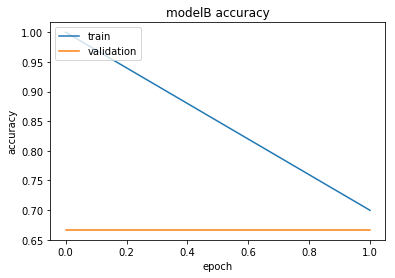

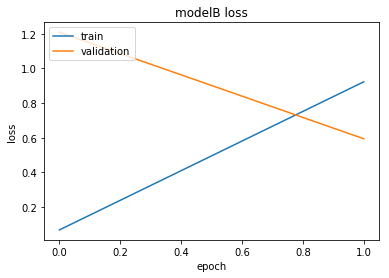

In [57]:
# modelB
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(historyB.history['accuracy'])
plt.plot(historyB.history['val_accuracy'])
plt.title('modelB accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.title('modelB loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



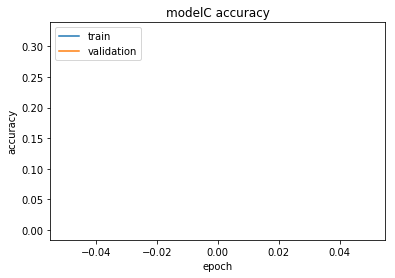

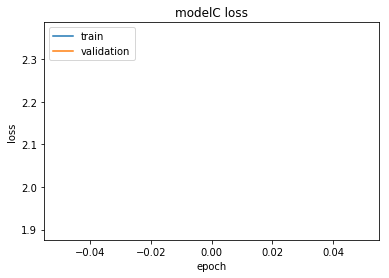

In [52]:
# modelC
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(historyC.history['accuracy'])
plt.plot(historyC.history['val_accuracy'])
plt.title('modelC accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyC.history['loss'])
plt.plot(historyC.history['val_loss'])
plt.title('modelC loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### Prediction
* TODO pole katsetatud, võetud siit:https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
* Proovin seda: https://stackoverflow.com/questions/48373685/keras-imagedatagenerator-how-to-get-all-labels-from-data

In [ ]:
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import math 
# re-initialize our testing data generator, this time for evaluating
img_seq_gen_test = ImageSequenceGenerator()
testGen = img_seq_gen_test.png_image_generator(path, bs=BS, mode="test", difficulty=difficulty, label_type = label_type, aug=None)

# next is try-out
test_batches = aug.flow_from_directory(path, batch_size=BS)
number_of_examples = len(test_batches.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 *BS)) 
test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_batches[i][1]))
#

# make predictions on the testing images, finding the index of the
# label with the corresponding largest predicted probability
predIdxs = model.predict(x=testGen, steps=(NUM_TEST_SEQ // BS) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(predIdxs)

# show a nicely formatted classification report
# testLabels=test_labels?
print("[INFO] evaluating network...")
print(classification_report(testLabels.argmax(axis=1), predIdxs,
	target_names=lb.classes_))